In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from calendar import month_name
pplt.rc['tick.minor']=False
warnings.filterwarnings('ignore')

In [2]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
COLORS  = {6:'#D42028',7:'#F2C85E',8:'#5BA7DA'}
MONTHPAIRS   = [(6,7),(7,8)]
SAMPLETHRESH = 50

In [3]:
def load(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds.load()

In [4]:
hrimergstats = load('HR_ERA5_IMERG_binned_stats.nc')
lrimergstats = load('LR_ERA5_IMERG_binned_stats.nc')
lrgpcpstats  = load('LR_ERA5_GPCP_binned_stats.nc')

The ```get_bin_mean_pr()``` function calculates the mean precipitation in each bin, and ```get_pdf()``` calculates either the regular or precipitating (points where precipitation > ```PRTHRESH```) probability density function (PDF). Both functions only run calculations for bins with more samples than ```SAMPLETHRESH```, and can be run for two cases: the 1D case (for $B_L$ bins) or 2D case (for joint $\mathrm{CAPE_L}$-$\mathrm{SUBSAT_L}$ bins).

In [5]:
def get_bin_mean_pr(monthstats,bintype,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        blbins = monthstats.bl.values
        Q0 = monthstats.Q0.values
        Q1 = monthstats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = monthstats.subsat.values
        capebins   = monthstats.cape.values
        P0 = monthstats.P0.values
        P1 = monthstats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'subsat':subsatbins,'cape':capebins})

def get_pdf(monthstats,bintype,precipitating=False):
    if bintype=='1D':
        blbins = monthstats.bl.values
        Q0 = monthstats.Q0.values
        QE = monthstats.QE.values
        Q  = QE if precipitating else Q0
        norm = np.nansum(Q0)*np.diff(blbins)[0]
        pdf  = Q/norm
        return xr.DataArray(pdf,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = monthstats.subsat.values
        capebins   = monthstats.cape.values
        P0 = monthstats.P0.values
        PE = monthstats.PE.values
        P  = PE if precipitating else P0
        norm = np.nansum(P0)*np.diff(subsatbins)[0]*np.diff(capebins)[0]
        pdf  = P/norm
        return xr.DataArray(pdf,coords={'subsat':subsatbins,'cape':capebins})

def get_mode(pdf,bintype,idxs=False):
    if bintype=='1D':
        blbins    = pdf.bl.values
        maxblidx  = np.nanargmax(pdf.values)
        blmode    = blbins[maxblidx]
        return blmode
    if bintype=='2D':
        subsatbins = pdf.subsat.values
        capebins   = pdf.cape.values
        maxsubsatidx,maxcapeidx = np.unravel_index(np.nanargmax(pdf.values),pdf.values.shape)
        if idxs:
            return maxsubsatidx,maxcapeidx
        subsatmode,capemode = subsatbins[maxsubsatidx],capebins[maxcapeidx]
        return subsatmode,capemode

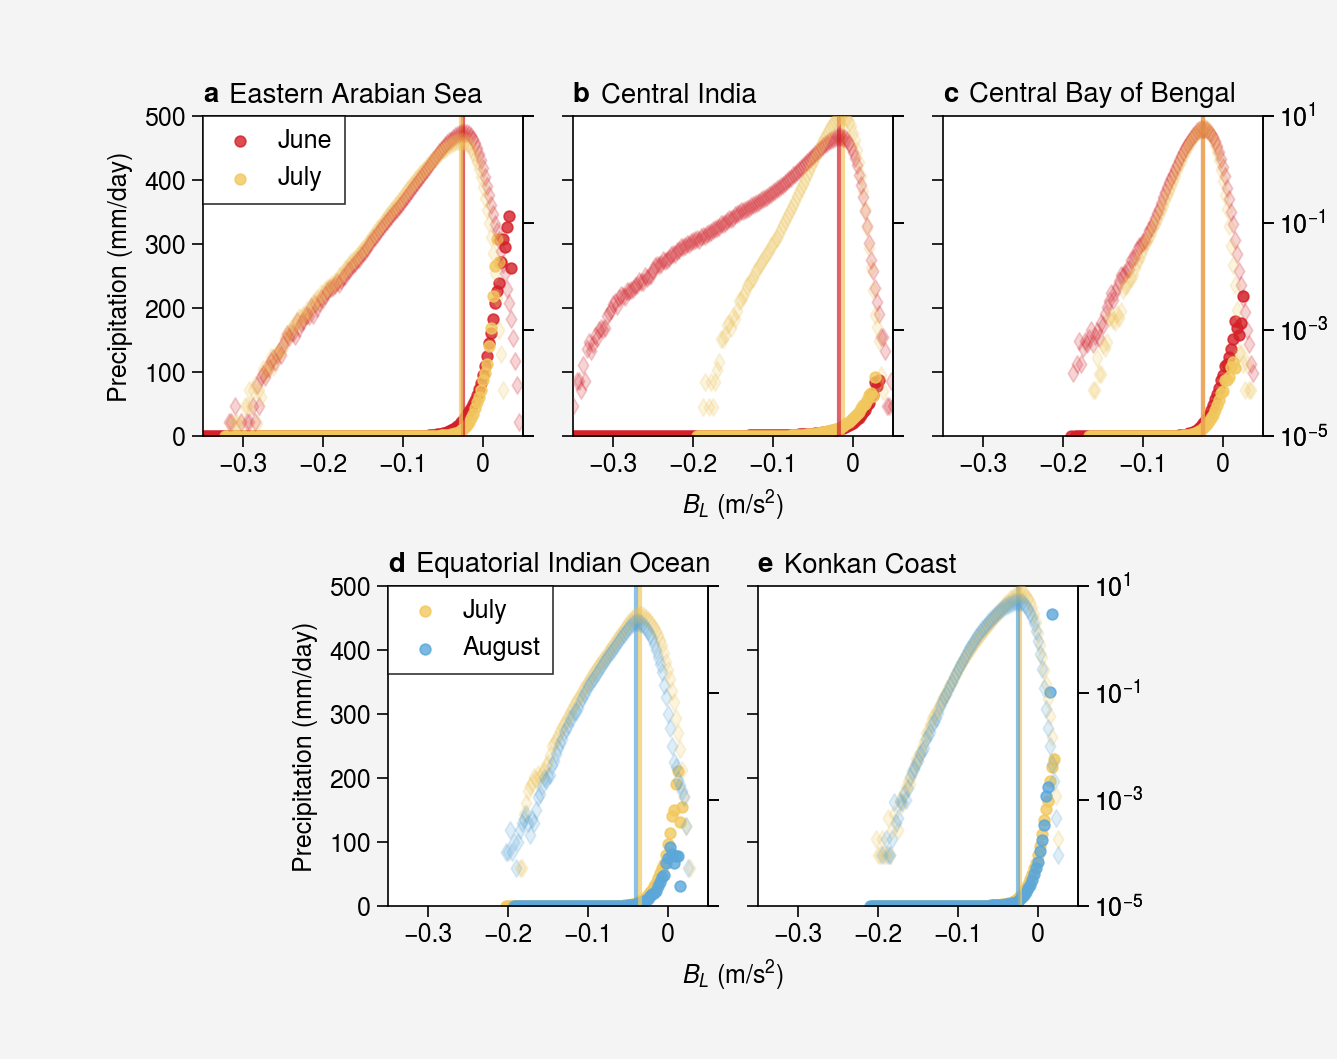

In [6]:
def create_plot(stats,monthpairs=MONTHPAIRS,samplethresh=SAMPLETHRESH,colors=COLORS,filename=None):
    fig,axs = pplt.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]],tight=False,abc=True,grid=False,
                            wspace='2em',hspace='6em',outerpad=3,refwidth=1.6)
    axs.format(xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.35,0.05),xticks=0.1,
               ylabel='Precipitation (mm/day)',ylim=(0,500),yticks=100)
    for i,region in enumerate(stats.region.values):
        ax,bx = axs[i],axs[i].twinx()
        ax.format(titleloc='l',title=f'{region}')
        bx.format(yscale='log',yformatter='log',ylim=(1e-5,1e1))
        if i in [0,1,3]:
            bx.format(yticklabels=[])
        monthpair = monthpairs[0] if i<3 else monthpairs[1]
        legendax  = axs[0] if i<3 else axs[3]
        for month in monthpair:
            monthstats = stats.sel(region=region,month=month)
            binmeanpr  = get_bin_mean_pr(monthstats,'1D',samplethresh)
            pdf   = get_pdf(monthstats,'1D',precipitating=True)
            mode  = get_mode(pdf,'1D')
            bx.scatter(pdf,color=colors[month],marker='d',markersize=20,alpha=0.1,zorder=0)
            ax.scatter(binmeanpr,color=colors[month],label=month_name[month],marker='o',markersize=15,alpha=0.8,zorder=1)
            ax.axvline(mode,color=colors[month],linestyle='-',linewidth=1.5,alpha=0.7,zorder=2)
        legendax.legend(loc='ul',ncols=1)
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

create_plot(hrimergstats,filename='fig_2.png')

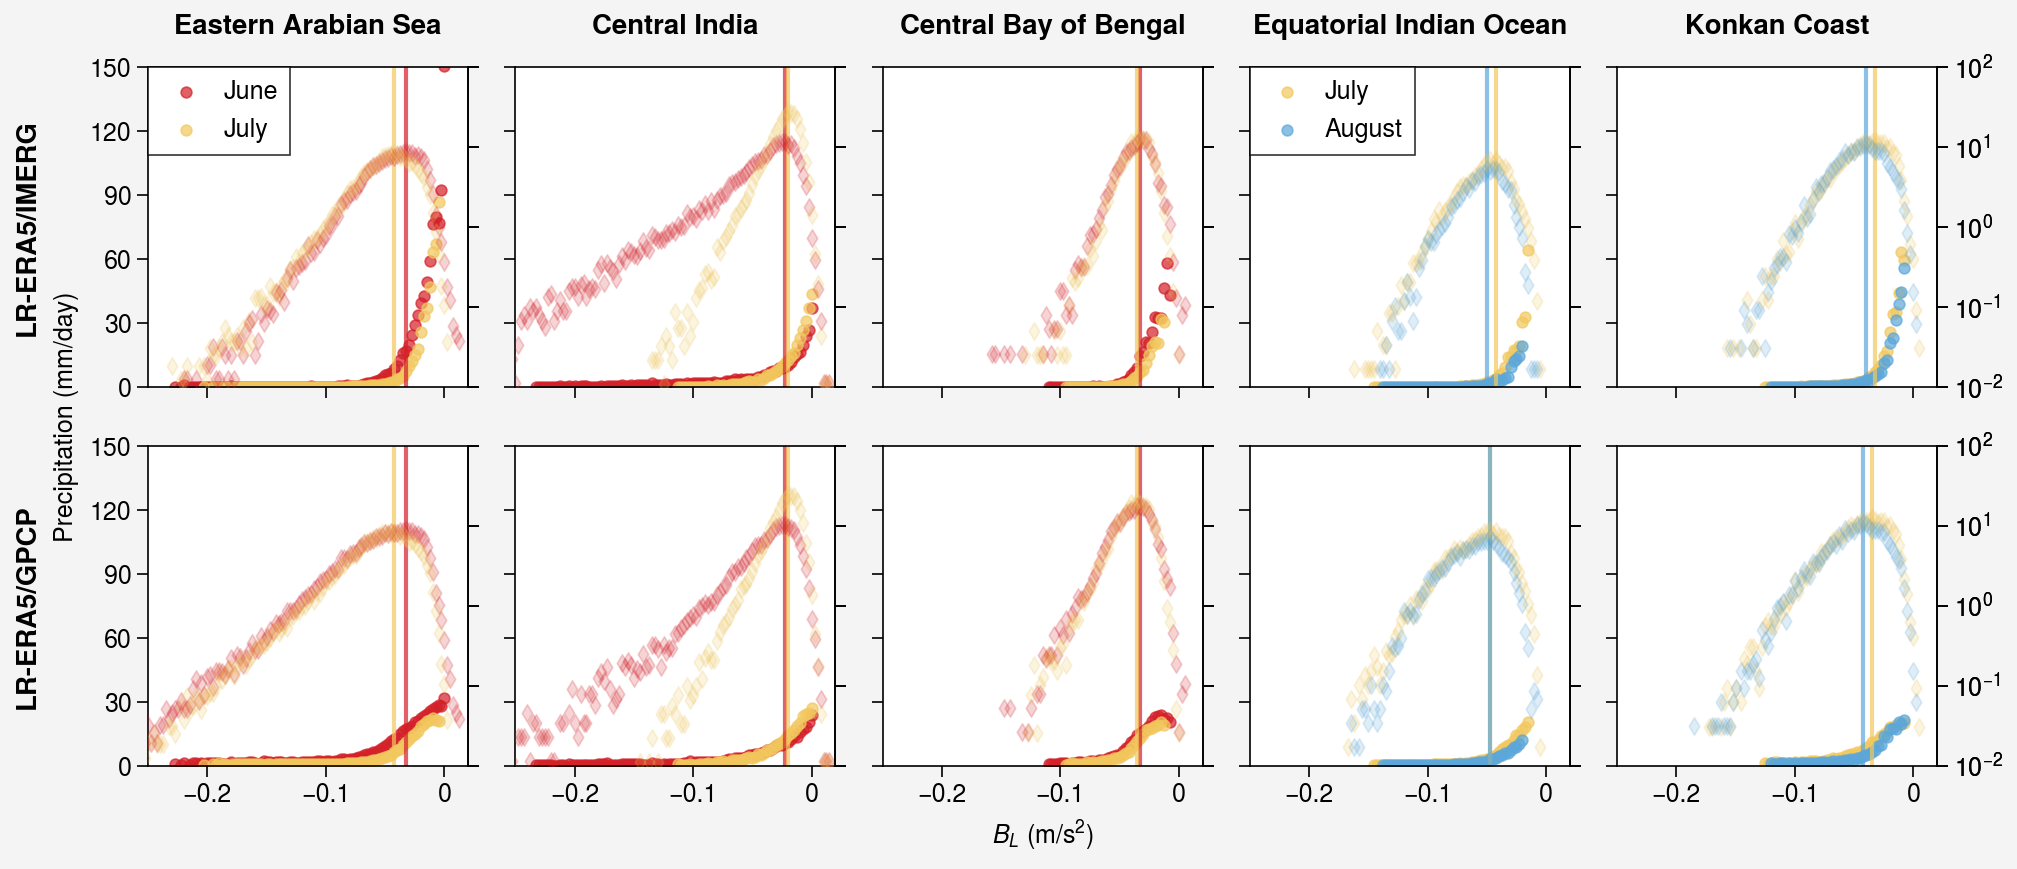

In [7]:
def create_si_plot(statsdict,monthpairs=MONTHPAIRS,samplethresh=SAMPLETHRESH,colors=COLORS,filename=None):
    statslist = [item[0] for item in statsdict]
    namelist  = [item[1] for item in statsdict]
    fig,axs = pplt.subplots(nrows=len(statslist),ncols=len(statslist[0].region),grid=False,refwidth=1.6)
    axs.format(rowlabels=namelist,collabels=list(statslist[0].region.values),
               xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.25,0.02),xticks=0.1,
               ylabel='Precipitation (mm/day)',ylim=(0,150),yticks=30)
    for i,stats in enumerate(statslist):
        for j,region in enumerate(stats.region.values):
            ax,bx = axs[i,j],axs[i,j].twinx()
            bx.format(yscale='log',yformatter='log',ylim=(1e-2,1e2),yminorticks='null')
            if j in [0,1,2,3,5,6,7,8]:
                bx.format(yticklabels=[])
            monthpair = monthpairs[0] if j<3 else monthpairs[1]
            for month in monthpair:
                monthstats = stats.sel(region=region,month=month)
                binmeanpr  = get_bin_mean_pr(monthstats,'1D',samplethresh)
                pdf  = get_pdf(monthstats,'1D',precipitating=True)
                mode = get_mode(pdf,'1D')
                bx.scatter(pdf,color=colors[month],marker='d',markersize=20,alpha=0.1,zorder=0)
                ax.scatter(binmeanpr,color=colors[month],label=month_name[month],marker='o',markersize=15,alpha=0.7,zorder=1)
                ax.axvline(mode,color=colors[month],linestyle='-',linewidth=1.5,alpha=0.7,zorder=2)
            if i==0 and j in [0,3]:
                ax.legend(loc='ul',ncols=1)
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)
        
statsdict = [
    (lrimergstats,'LR-ERA5/IMERG'),
    (lrgpcpstats,'LR-ERA5/GPCP')]
create_si_plot(statsdict,filename='fig_S2.png')